In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from kolesky import cholesky

In [19]:
def logdet_chol(A):
    return 2 * np.sum(np.log(A.diagonal()))

def kl_div(A, B):
    n = A.shape[0]
    return 0.5 * (np.trace(np.linalg.solve(B, A)) - n + np.linalg.slogdet(B)[1] - np.linalg.slogdet(A)[1])

def sparse_kl_div(A, L):
    n = A.shape[0]
    return 0.5 * (-logdet_chol(L) - np.linalg.slogdet(A)[1])

In [20]:
with open('13x13iso1024.pickle', 'rb') as f:
    data = pickle.load(f)

print(data.shape)

(5028, 169, 3)


In [21]:
nx = 13
ny = 1
nz = 13
# x_points = np.linspace(0.0, 18 * np.pi / 1024, nx, dtype = np.float64)
# x_points = np.linspace(0.0, 18 * np.pi / 512, nx, dtype = np.float64)
# x_points = np.linspace(0.0, 98 * np.pi / 512, nx, dtype = np.float64)
y_points = np.pi / 2
x_points = np.linspace(0.0, 24 * np.pi / 512, nx, dtype = np.float64)
# y_points = np.linspace(0.0, 24 * np.pi / 512, ny, dtype = np.float64)
z_points = np.linspace(0.0, 24 * np.pi / 512, nz, dtype = np.float64)
# y_points = np.linspace(0.0, 18 * np.pi / 512, ny, dtype = np.float64)
# z_points = np.linspace(0.0, 18 * np.pi / 1024, nz, dtype = np.float64)
# z_points = np.linspace(0.0, 18 * np.pi / 512, nz, dtype = np.float64)
# z_points = np.linspace(0.0, 98 * np.pi / 512, nz, dtype = np.float64)
points = np.array([axis.ravel() for axis in np.meshgrid(x_points, y_points, z_points, indexing = 'ij')], dtype = np.float64).T

In [22]:
x_velocity = data[:, :, 0]
y_velocity = data[:, :, 1]
z_velocity = data[:, :, -1]

In [23]:
L, order = cholesky.kl_cholesky(points, x_velocity, 4.0, 1.5)

In [24]:
L = L.toarray()
ordered_x_velocity = x_velocity[:, order]
x_cov = np.cov(ordered_x_velocity, rowvar = False, bias = True)
kl = sparse_kl_div(x_cov, L)
print('KL divergence:', kl)
kl = kl_div(x_cov, np.linalg.inv(L @ L.T))
print('KL divergence:', kl)

KL divergence: 10.138606365197461
KL divergence: 10.13860636518666


In [25]:
from scipy.spatial import KDTree
import scipy.linalg
import scipy.sparse as sparse

def col(theta):
    m = np.linalg.inv(theta)
    return m[:, 0] / np.sqrt(m[0, 0])

def __supernodes(sparsity, lengths, lamb):
    groups = []
    candidates = set(range(len(lengths)))
    agg_sparsity = {}
    i = 0
    while len(candidates) > 0:
        while i not in candidates:
            i += 1
        group = sorted(j for j in sparsity[i] if lengths[j] <= lamb * lengths[i] and j in candidates)
        groups.append(group)
        candidates -= set(group)
        s = sorted({k for j in group for k in sparsity[j]})
        agg_sparsity[group[0]] = s
        positions = {k: j for j, k in enumerate(s)}
        for j in group[1:]:
            agg_sparsity[j] = np.empty(len(s) - positions[j], dtype=int)
    return groups, agg_sparsity

def chol(points, covariance, sparsity):
    n = len(points)
    ptr = np.cumsum([0] + [len(sparsity[i]) for i in range(n)])
    data, indices = np.zeros(ptr[-1]), np.zeros(ptr[-1])
    for i in range(n):
        s = sorted(sparsity[i])
        theta = np.zeros((len(s), len(s)))
        for j in range(len(s)):
            for k in range(len(s)):
                theta[j, k] = covariance[s[j], s[k]]
        c = col(theta)
        data[ptr[i] : ptr[i + 1]] = c
        indices[ptr[i] : ptr[i + 1]] = s
    return sparse.csc_matrix((data, indices, ptr), shape=(n, n))

def __cols(theta):
    return np.flip(np.linalg.cholesky(np.flip(theta))).T

def __aggregate_chol(points, velocity, sparsity, groups):
    n = len(points)
    ptr = np.cumsum([0] + [len(sparsity[i]) for i in range(n)])
    data, indices = np.zeros(ptr[-1]), np.zeros(ptr[-1])
    for group in groups:
        s = sorted(sparsity[group[0]])
        positions = {i: k for k, i in enumerate(s)}
        data_group = np.cov(velocity[:, s], rowvar=False, bias=True)
        L_group = __cols(data_group)
        for i in group:
            k = positions[i]
            e_k = np.zeros(len(s))
            e_k[k] = 1
            col = scipy.linalg.solve_triangular(L_group, e_k, lower=True, check_finite=False)
            data[ptr[i] : ptr[i + 1]] = col[k:]
            indices[ptr[i] : ptr[i + 1]] = s[k:]
    return sparse.csc_matrix((data, indices, ptr), shape=(n, n))

def reverse_maximin(points):
    n = np.shape(points)[0]
    indices = np.zeros(n, dtype=int)
    lengths = np.zeros(n, dtype=float)
    dists = np.linalg.norm(points - points[0], axis=1)
    indices[-1] = 0
    lengths[0] = np.inf
    for i in range(n - 2, -1, -1):
        k = np.argmax(dists)
        indices[i] = k
        lengths[i] = dists[k]
        dists = np.minimum(dists, np.linalg.norm(points[k] - points, axis=1))
    return indices, lengths

def sparsity_pattern(points, lengths, rho):
    tree, offset, length_scale = KDTree(points), 0, lengths[0]
    sparsity = {}
    for i in range(len(points)):
        if lengths[i] > 2 * length_scale:
            tree, offset, length_scale = KDTree(points[i:]), i, lengths[i]
        sparsity[i] = [
            offset + j
            for j in tree.query_ball_point(points[i], rho * lengths[i])
            if offset + j >= i
        ]
    return sparsity

In [26]:
def kl_plot(points, data):
    order, lengths = reverse_maximin(points)
    ordered_points = points[order]
    ordered_data = data[:, order]
    cov = np.cov(ordered_data, rowvar=False, bias=True)
    delta = 0.3
    for i in range(1, 20):
        rho = 4.0 + i * delta
        sparsity = sparsity_pattern(ordered_points, lengths, rho)
        groups, agg_sparsity = __supernodes(sparsity, lengths, 1.5)
        L = __aggregate_chol(points, ordered_data, agg_sparsity, groups)
        # print(L)
        kl = sparse_kl_div(cov, L)
        print(rho, kl)
        plt.scatter(rho, np.log(kl), color='blue')
        plt.xlabel("rho")
        plt.ylabel("log(KL(Theta, inv(LL^T)))")
    plt.show()

4.3 7.62039738826536
4.6 6.979743324863762
4.9 6.822946935122673
5.2 4.307343402107676
5.5 3.6300958031041546
5.8 3.0586108019647327
6.1 1.9127262433379428
6.4 1.7641697734509307
6.699999999999999 1.1286470800805546
7.0 0.8556513267078572
7.3 0.680118093521628
7.6 0.6281319390598128
7.9 0.48051053091523954
8.2 0.4179643282413963
8.5 0.4432376752050686
8.8 0.36616240703835956
9.1 0.31632821621440144
9.399999999999999 0.26718343050083604
9.7 0.236866380683864


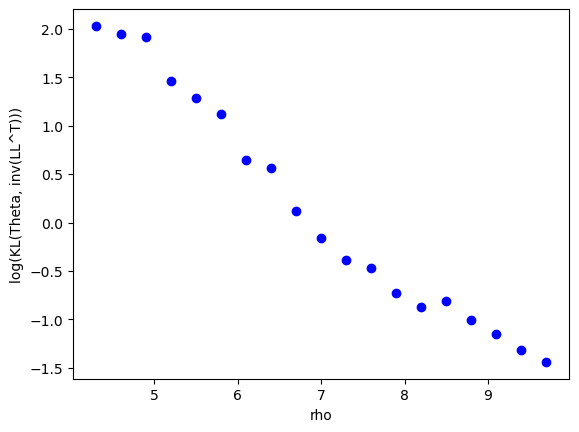

In [27]:
kl_plot(points, x_velocity)